# A year in the life of an athlete with type 1 diabetes: descriptives

Descriptives and analysis for the 2019 training season of 11 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from helper import month_mapping, month_firstday
from calc import glucose_levels, mmoll_mgdl, mgdl_mmoll
from config import DATA_PATH as RAW_PATH

from secret import rider_mapping
rider_mapping_inv = {v:k for k, v in rider_mapping.items()}

DATA_PATH = 'data/'
SAVE_PATH = 'descriptives/dexcom/'

if not os.path.exists(SAVE_PATH):
	os.mkdir(SAVE_PATH)
if not os.path.exists(SAVE_PATH+'availability/'):
	os.mkdir(SAVE_PATH+'availability/')
if not os.path.exists(SAVE_PATH+'hist/'):
	os.mkdir(SAVE_PATH+'hist/')
if not os.path.exists(SAVE_PATH+'boxplot/'):
	os.mkdir(SAVE_PATH+'boxplot/')
if not os.path.exists(SAVE_PATH+'time_in_zone/'):
	os.mkdir(SAVE_PATH+'time_in_zone/')
if not os.path.exists(SAVE_PATH+'time_cycling/'):
	os.mkdir(SAVE_PATH+'time_cycling/')

In [2]:
# color settings
color_palette = sns.color_palette("Set1")
color_sec = {'wake'	: color_palette[1],
			 'ex': color_palette[4],
			 'post-ex': color_palette[2],
			 'sleep': color_palette[3]}
palette_sec = {	'wake'	: sns.color_palette('Blues', n_colors=11),
				'ex'	: sns.color_palette('Oranges', n_colors=11),
				'post-ex'	: sns.color_palette('Greens', n_colors=11),
				'sleep'	: sns.color_palette('Purples', n_colors=11)}
palette_ath = sns.color_palette("tab10")+[(0.106, 0.62, 0.467)]#sns.color_palette("viridis_r", n_colors=11)
color_race = {'training':color_palette[8], 'race':(0.8455062527192158, 0.21363575247920147, 0.4145075850498335)}

In [3]:
def get_percinlevel(df, col='Glucose Value (mg/dL)'):
	return {level: ((df[col] >= lmin) & (df[col] <= lmax)).sum() / len(df)*100 for level, (lmin, lmax) in glucose_levels.items()}

### Read data

Athlete characteristics

In [4]:
info = pd.read_csv(DATA_PATH+'info.csv', index_col=0)
info.set_index('RIDER', inplace=True)

CGM data (RAW)

In [5]:
df_raw = pd.read_csv(RAW_PATH+'dexcom.csv', index_col=0)
df_raw.drop('local_timestamp_raw', axis=1, inplace=True)

df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df_raw['local_timestamp'] = pd.to_datetime(df_raw['local_timestamp'])

# select glucose measurements
df_raw = df_raw[df_raw['Event Type'] == 'EGV']
df_raw = df_raw[['RIDER', 'timestamp', 'local_timestamp', 'Source Device ID', 'Glucose Value (mg/dL)',
				 'Transmitter ID', 'Transmitter Time (Long Integer)', 'source', 'training']]

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (3,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


CGM data (resampled and clean)

In [6]:
# read CGM data : resampled + completeness selection + incl sections
df = pd.read_csv(DATA_PATH+'dexcom_clean_nocomp.csv', index_col=0)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['local_timestamp'] = pd.to_datetime(df['local_timestamp'])

# filter completeness
df = df[df['completeness'] >= 0.7]
df.dropna(subset=['Glucose Value (mg/dL)'], inplace=True)
df.reset_index(drop=True, inplace=True)

# rename sections
df.rename(columns={'train':'ex', 'post':'post-ex'}, inplace=True)

In [7]:
# transform sections to bool
SECTIONS = ('wake', 'ex', 'post-ex', 'sleep')
for sec in SECTIONS:
	df[sec] = df[sec].astype(bool)
# TODO: so far no exclusions from different sections

In [8]:
COL = 'Glucose Value (mg/dL)'

In [9]:
ATHLETES = df.RIDER.unique()

In [10]:
MAX_READINGS = 24*60/5+1

## Glucose availability

Calendar with glucose availability

### RAW

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Use the colorbar set_ticks() method instead.
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


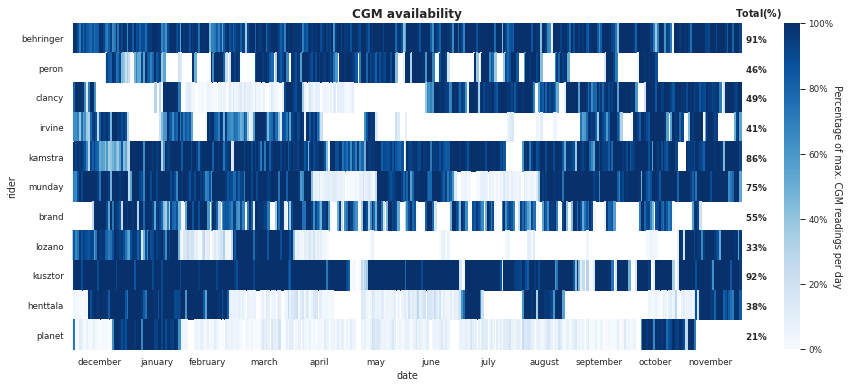

In [11]:
# -------------------------- Glucose availability (1 - raw)
# create calendar with glucose availability
df_avail = df_raw.groupby(['RIDER', df_raw.timestamp.dt.date])['Glucose Value (mg/dL)'].count().unstack() / MAX_READINGS

# plot glucose availability per day
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.heatmap(df_avail, cmap='Blues', vmin=0, vmax=1)

# put total percentage on RHS
ax2 = ax.secondary_yaxis("right")
ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
ax2.set_yticklabels([r"$\bf{:.0f}\%$".format(i) for i in df_avail.sum(axis=1)/365*100])
ax2.tick_params(axis='y', length=0)
ax2.spines['right'].set_visible(False)
ax.text(0.99, 1.02, r'$\bf{:s}$'.format('Total (\%)'), ha='left', transform=ax.transAxes)

# adjust ticks colorbar
cbar_ax = fig.get_axes()[1]
cbar_ax.set_yticks([0, .2, .4, .6, .8, 1.])
cbar_ax.set_yticklabels(["{:.0f}%".format(i*100) for i in [0, .2, .4, .6, .8, 1.]])
cbar_ax.text(3., 0.5, 'Percentage of max. CGM readings per day', va='center', rotation=270)

plt.xticks(ticks=[d+15 for d in month_firstday.values()], labels=[list(month_firstday.keys())[-1]]+list(month_firstday.keys())[:-1], rotation=0)
plt.xlabel('date')
plt.ylabel('rider')
plt.title('CGM availability', fontweight='bold', fontsize=12)

plt.savefig(SAVE_PATH+'availability/glucose_availability_RAW.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'availability/glucose_availability_RAW.png', dpi=300, bbox_inches='tight')
ax.set_yticklabels([rider_mapping_inv[int(i.get_text())] for i in ax.get_yticklabels()], rotation=0)
plt.savefig(SAVE_PATH+'availability/glucose_availability_RAW_NAME.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'availability/glucose_availability_RAW_NAME.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

### CLEAN

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Use the colorbar set_ticks() method instead.
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator


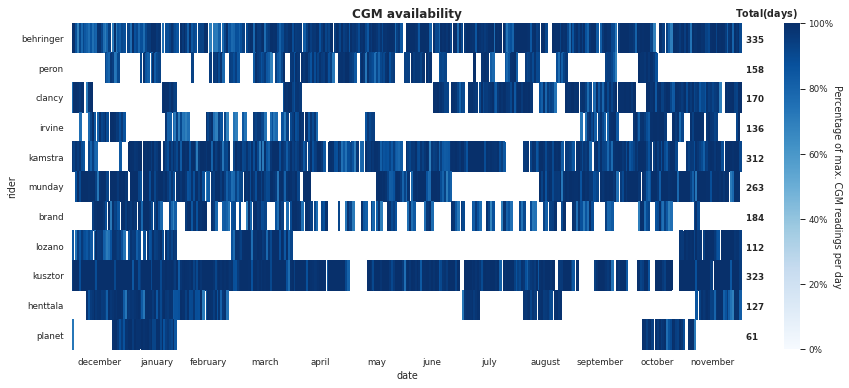

In [12]:
df_avail = df.groupby(['RIDER', df.timestamp.dt.date])['Glucose Value (mg/dL)'].count().unstack() / MAX_READINGS
info['cgm_days'] = df_avail.count(axis=1)

# plot glucose availability per day
fig, ax = plt.subplots(figsize=(15,6))
ax = sns.heatmap(df_avail, cmap='Blues', vmin=0, vmax=1)

# put total percentage on RHS
ax2 = ax.secondary_yaxis("right")
ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
ax2.set_yticklabels([r"$\bf{:.0f}$".format(i) for i in df_avail.count(axis=1)])
ax2.tick_params(axis='y', length=0)
ax2.spines['right'].set_visible(False)
ax.text(0.99, 1.02, r'$\bf{:s}$'.format('Total (days)'), ha='left', transform=ax.transAxes)

# adjust ticks colorbar
cbar_ax = fig.get_axes()[1]
cbar_ax.set_yticks([0, .2, .4, .6, .8, 1.])
cbar_ax.set_yticklabels(["{:.0f}%".format(i*100) for i in [0, .2, .4, .6, .8, 1.]])
#cbar_ax.set_title('Days with CGM readings')
cbar_ax.text(3., 0.5, 'Percentage of max. CGM readings per day', va='center', rotation=270)

plt.xticks(ticks=[d+15 for d in month_firstday.values()], labels=[list(month_firstday.keys())[-1]]+list(month_firstday.keys())[:-1], rotation=0)
plt.xlabel('date')
plt.ylabel('rider')
plt.title('CGM availability', fontweight='bold', fontsize=12)

plt.savefig(SAVE_PATH+'availability/glucose_availability.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'availability/glucose_availability.png', dpi=300, bbox_inches='tight')
ax.set_yticklabels([rider_mapping_inv[int(i.get_text())] for i in ax.get_yticklabels()], rotation=0)
plt.savefig(SAVE_PATH+'availability/glucose_availability_NAME.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'availability/glucose_availability_NAME.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Glucose distribution (histograms)

In [13]:
def plot_hist_glucose_settings(ax, ax0, col='Glucose Value (mg/dL)', xlim=(20,410), ylabel='Probability', loc_legend=(1., 0.96)):
	ax.set_xlim((20, 410))
	ax.set_xlabel(col)
	ax.xaxis.set_visible(True)
	ax.set_ylabel(ylabel)
	ax.yaxis.set_ticks_position('left')
	ax.yaxis.set_label_position('left')
	ax0.yaxis.set_visible(False)
	ax0.set_ylabel('')
	plt.legend(loc='upper right', bbox_to_anchor=loc_legend, prop={'family': 'DejaVu Sans Mono', 'size':8})

All data

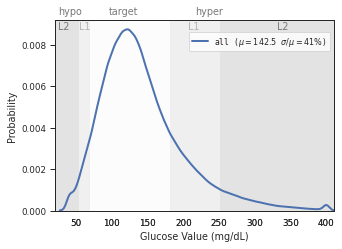

In [14]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
sns.kdeplot(df[COL], ax=ax, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(df[COL].mean(), df[COL].std()/df[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
plt.savefig(SAVE_PATH+'hist/hist_glucose.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'hist/hist_glucose.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

All, hue: sections

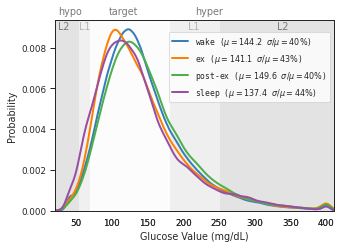

In [15]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(df[df[sec]][COL], ax=ax, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(df[df[sec]][COL].mean(), df[df[sec]][COL].std()/df[df[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
plt.savefig(SAVE_PATH+'hist/hist_glucose_sec.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'hist/hist_glucose_sec.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Individual athletes, hue: sections

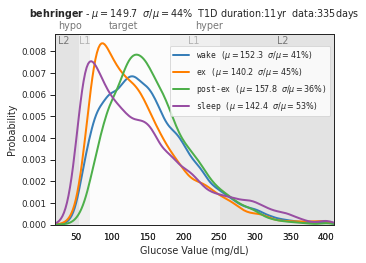

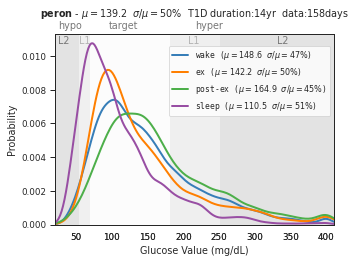

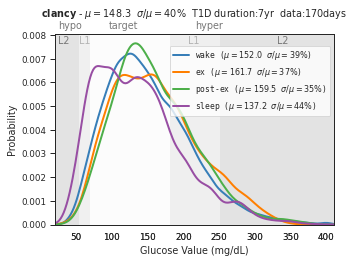

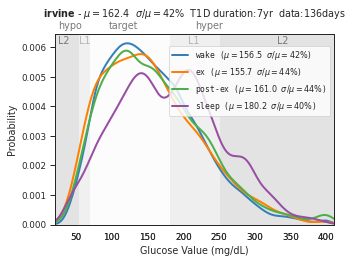

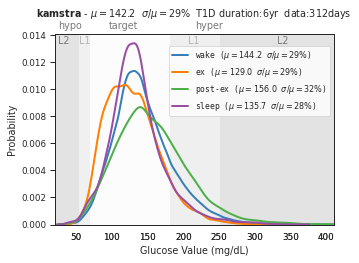

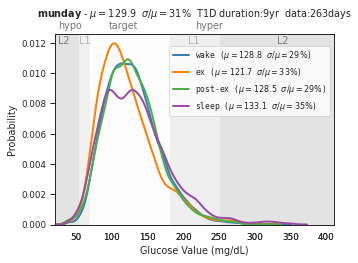

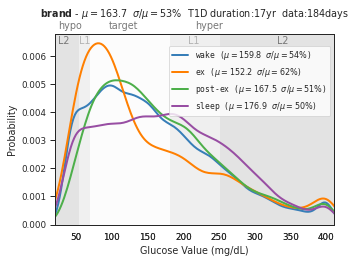

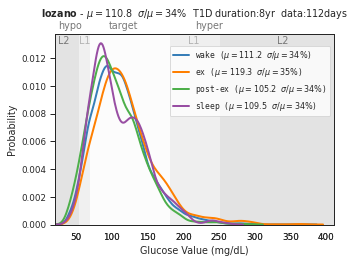

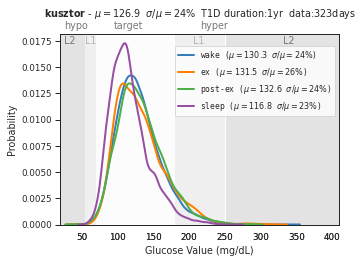

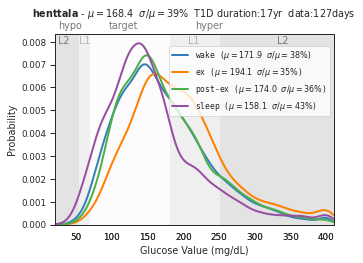

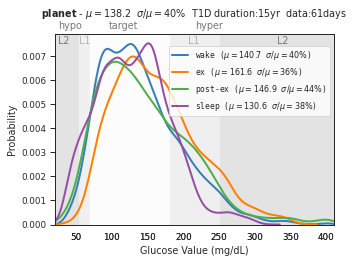

In [16]:
for i in df.RIDER.unique():
	fig, ax0 = plt.subplots(figsize=(5, 3.5))
	ax0 = plot_glucose_levels(ax0, color=False)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(df[df[sec]][df[df[sec]].RIDER == i][COL], ax=ax, linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(df[df[sec]][df[df[sec]].RIDER == i][COL].mean(), 
					df[df[sec]][df[df[sec]].RIDER == i][COL].std()/df[df[sec]][df[df[sec]].RIDER == i][COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	plt.title(r'$\bf{Rider}$ '+r'$\bf{:d}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(i, df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']), y=1.06)
	plt.savefig(SAVE_PATH+'hist/hist_glucose_sec_%s.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'hist/hist_glucose_sec_%s.png'%i, dpi=300, bbox_inches='tight')
	plt.title(r'$\bf{:s}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(rider_mapping_inv[i], df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']), y=1.06)
	plt.savefig(SAVE_PATH+'hist/hist_glucose_sec_NAME_%s.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'hist/hist_glucose_sec_NAME_%s.png'%i, dpi=300, bbox_inches='tight')	
	plt.show()
	plt.close()

All, hue: athletes

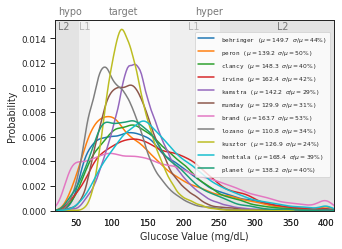

In [17]:
fig, ax0 = plt.subplots(figsize=(5, 3.5))
ax0 = plot_glucose_levels(ax0, color=False)
ax = ax0.twinx()
for c, i in enumerate(df.RIDER.unique()):
	sns.kdeplot(df[df.RIDER == i][COL], ax=ax, 
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(df[df.RIDER == i][COL].mean(), 
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
for text in ax.get_legend().get_texts(): # smaller fontsize
	text.set_fontsize(6)
plt.savefig(SAVE_PATH+'hist/hist_glucose_riders.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'hist/hist_glucose_riders.png', dpi=300, bbox_inches='tight')
for c, i in enumerate(df.RIDER.unique()):
	text = ax.get_legend().get_texts()[c].get_text().split()
	ax.get_legend().get_texts()[c].set_text(rider_mapping_inv[int(text[0])]+' '+' '.join(text[1:]))
plt.savefig(SAVE_PATH+'hist/hist_glucose_riders_NAME.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'hist/hist_glucose_riders_NAME.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Sections individually, hue: athletes

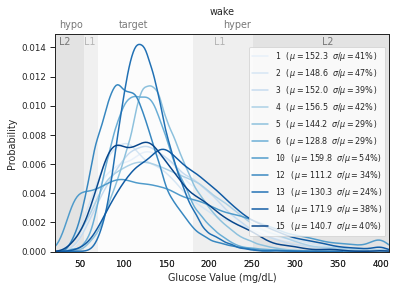

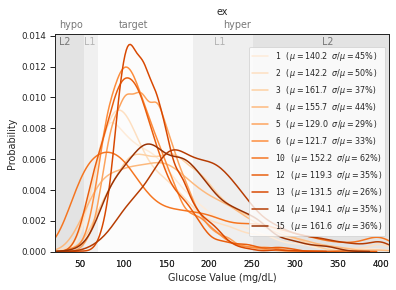

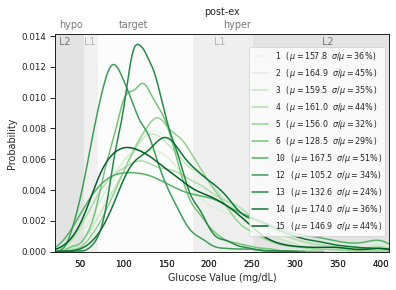

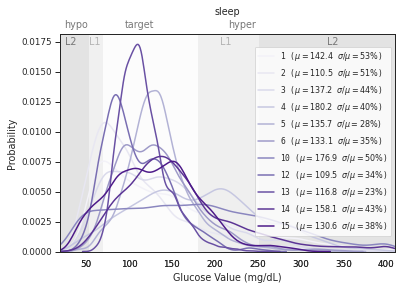

In [18]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0, color=False)
	ax = ax0.twinx()
	for c, i in enumerate(df.RIDER.unique()):
		sns.kdeplot(df[df[sec]][df[df[sec]].RIDER == i][COL], ax=ax, 
			linewidth=1.5, color=palette_sec[sec][c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(df[df[sec]][df[df[sec]].RIDER == i][COL].mean(), 
					df[df[sec]][df[df[sec]].RIDER == i][COL].std()/df[df[sec]][df[df[sec]].RIDER == i][COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	plt.title(sec, y=1.06)
	plt.savefig(SAVE_PATH+'hist/hist_glucose_sec_%s.pdf'%sec, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'hist/hist_glucose_sec_%s.png'%sec, dpi=300, bbox_inches='tight')
	plt.show()
	plt.close()

## Glucose time in level (barcharts)

In [19]:
def plot_bar(data, x, width=.8, colors=dict(h_neg=10, h_pos=10, s=0, l=50)):
	hatch = ('\\\\', '\\\\', None, '//', '//')
	color_palette = sns.diverging_palette(**colors, n=5)
	bottom = 0
	for i, (label, y) in enumerate(data.items()):
		plt.bar(x=x, height=y, width=width, bottom=bottom, color=color_palette[i], hatch=hatch[i])
		bottom += y

In [20]:
legend_elements = [Patch(facecolor=c, edgecolor='white', hatch=h, label=l) \
					for c, l, h in zip(sns.diverging_palette(10, 10, s=0, n=5), 
									   list(glucose_levels.keys())[::-1], 
									   ('///', '///', None, '\\\\\\', '\\\\\\'))] 

colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_sec.values()]]

All, hue: stages

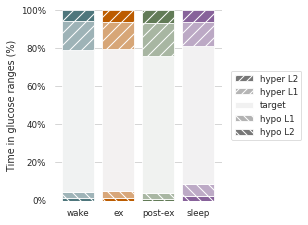

In [21]:
# TODO: now it is dominated by athletes that have the most data, 
# we should calculate it for riders individually and then average
fig, ax = plt.subplots(figsize=(3, 3.5))
for k, sec in enumerate(SECTIONS):
	pil = get_percinlevel(df[df[sec]])
	plot_bar(pil, x=k, colors=colors[k])

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glucose ranges (%)')

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.yaxis.grid(True)
sns.despine(left=True, bottom=True, right=True)

plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Individual athletes, hue: stages

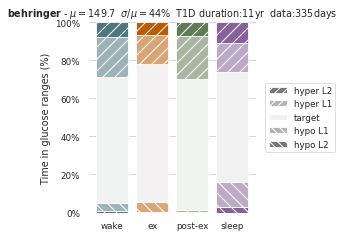

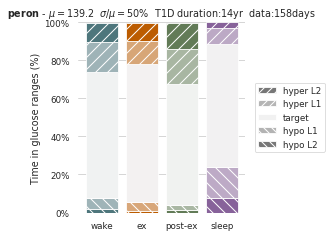

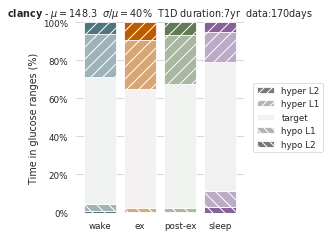

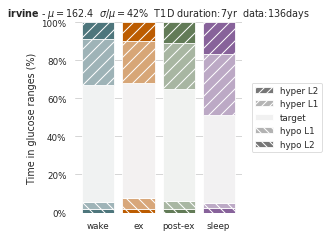

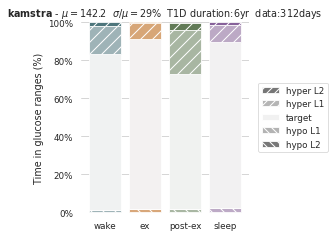

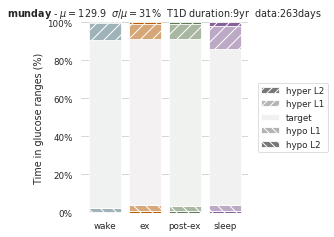

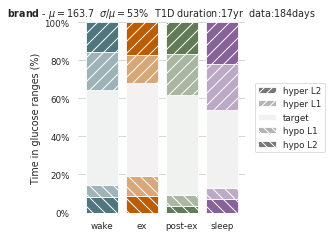

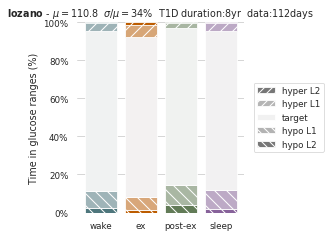

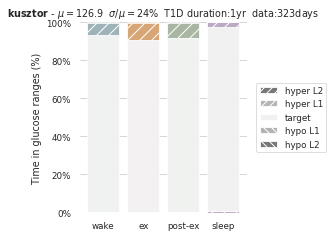

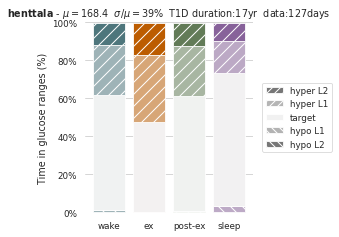

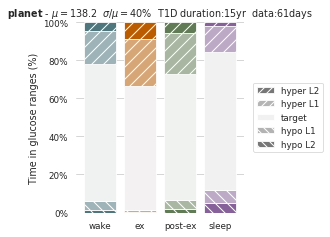

In [22]:
for i in df.RIDER.unique():
	fig, ax = plt.subplots(figsize=(3, 3.5))
	for k, sec in enumerate(SECTIONS):
		pil = get_percinlevel(df[df[sec]][df[df[sec]].RIDER == i])
		plot_bar(pil, x=k, colors=colors[k])

	plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
	plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
	plt.ylim((0,100))
	plt.ylabel('Time in glucose ranges (%)')

	ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
	ax.yaxis.grid(True)
	sns.despine(left=True, bottom=True, right=True)

	plt.title(r'$\bf{Rider}$ '+r'$\bf{:d}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(i, df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_%s.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_%s.png'%i, dpi=300, bbox_inches='tight')
	plt.title(r'$\bf{:s}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(rider_mapping_inv[i], df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_%s_NAME.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_%s_NAME.png'%i, dpi=300, bbox_inches='tight')
	plt.show()
	plt.close()

All, hue: athletes

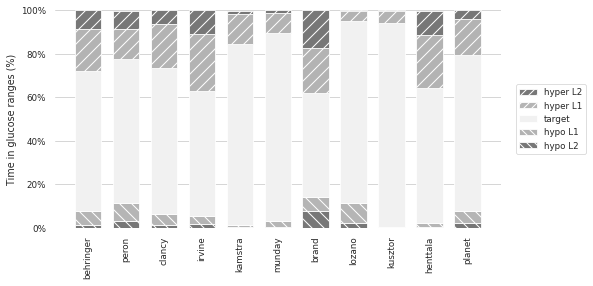

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
for n, i in enumerate(df.RIDER.unique()):
	pil = get_percinlevel(df[df.RIDER == i])
	plot_bar(pil, x=n, width=.7)

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(df.RIDER.unique())), df.RIDER.unique())
plt.ylim((0,100))
plt.ylabel('Time in glucose ranges (%)')

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.2, 0.5))
ax.yaxis.grid(True)
sns.despine(left=True, bottom=True, right=True)

plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_riders.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_riders.png', dpi=300, bbox_inches='tight')
ax.set_xticklabels([rider_mapping_inv[int(i.get_text())] for i in ax.get_xticklabels()], rotation=90)
plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_riders_NAME.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_riders_NAME.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [24]:
# race vs no race
colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_race.values()]]

All, hue: race

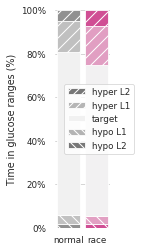

In [25]:
fig, ax = plt.subplots(figsize=(1,4))
for k, b in enumerate([False, True]):
	pil = get_percinlevel(df[df['race'] == b])
	plot_bar(pil, x=k, colors=colors[k])

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(2), [j for j in color_race.keys()])
plt.ylim((0,100))
plt.ylabel('Time in glucose ranges (%)')

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
ax.yaxis.grid(True)
sns.despine(left=True, bottom=True, right=True)

plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_race.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_race.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Individual athletes, hue: race

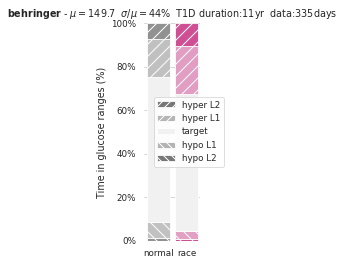

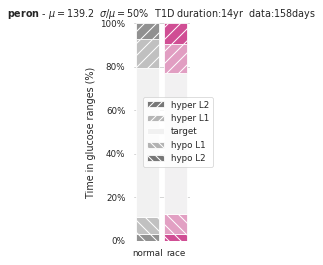

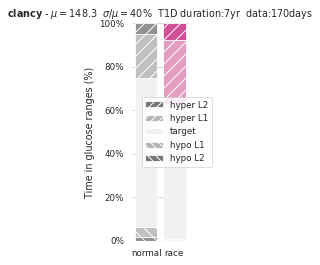

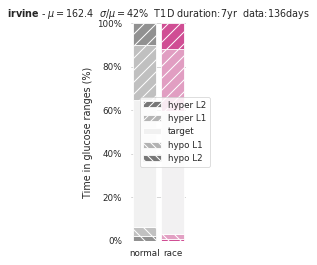

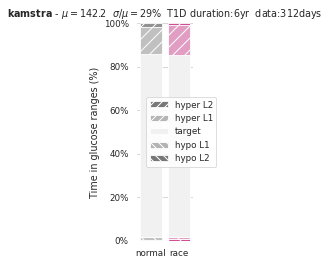

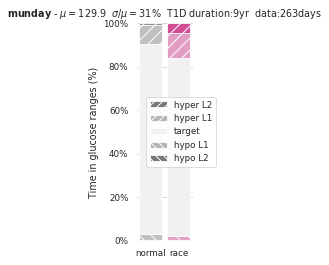

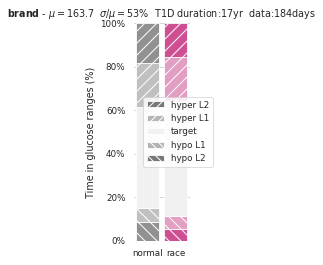

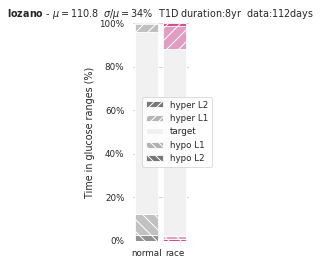

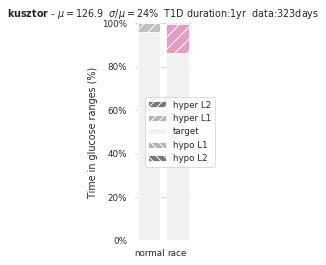

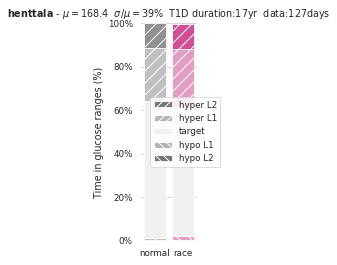

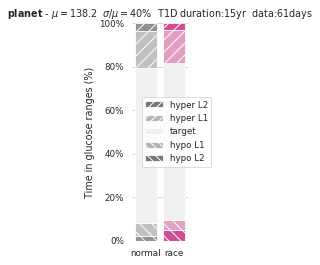

In [26]:
for i in df.RIDER.unique():
	fig, ax = plt.subplots(figsize=(1,4))
	for k, b in enumerate([False, True]):
		pil = get_percinlevel(df[(df.RIDER == i) & (df['race'] == b)])
		plot_bar(pil, x=k, colors=colors[k])

	plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
	plt.xticks(np.arange(2), [j for j in color_race.keys()])
	plt.ylim((0,100))
	plt.ylabel('Time in glucose ranges (%)')

	ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.5, 0.5))
	ax.yaxis.grid(True)
	sns.despine(left=True, bottom=True, right=True)

	plt.title(r'$\bf{Rider}$ '+r'$\bf{:d}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(i, df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_race_%s.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_race_%s.png'%i, dpi=300, bbox_inches='tight')
	plt.title(r'$\bf{:s}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(rider_mapping_inv[i], df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_race_%s_NAME.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'time_in_zone/time_in_glucoselevel_race_%s_NAME.png'%i, dpi=300, bbox_inches='tight')
	plt.show()
	plt.close()

## Glucose distribution (boxplots)

In [27]:
rc = color_race['race'] ; nc = color_race['training']

kws_box = {'race':	dict(boxprops=dict(color='w', facecolor=rc, hatch='\\\\\\'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=rc), capprops=dict(color=rc)),
		   'training':dict(boxprops=dict(color='w', facecolor=nc, hatch='///'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=nc), capprops=dict(color=nc))}

df['date'] = df['local_timestamp'].dt.date

All, stratify: sections

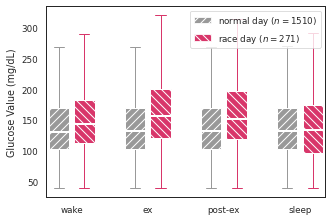

In [28]:
n_nc = len(df.loc[df['race'] == False, ['RIDER', 'date']].drop_duplicates())
n_rc = len(df.loc[df['race'] == True, ['RIDER', 'date']].drop_duplicates())

fig, ax = plt.subplots(figsize=(5,3.5))
for k, sec in enumerate(SECTIONS):
	plt.boxplot(df.loc[df[sec] & df['race']==False, COL], positions=[k+0.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['training'])
	plt.boxplot(df.loc[df[sec] & df['race']==True, COL], positions=[k+1.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.xticks([1,4,7,10], SECTIONS)
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=nc, edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=rc, edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.savefig(SAVE_PATH+'boxplot/box_glucose_sections.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'boxplot/box_glucose_sections.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Individual athletes, stratify: sections

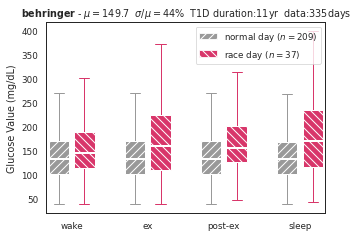

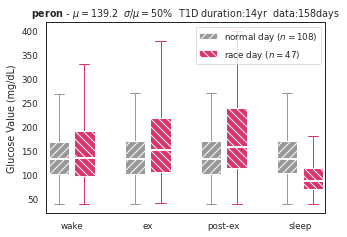

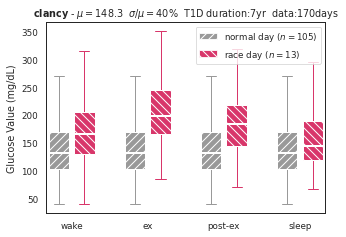

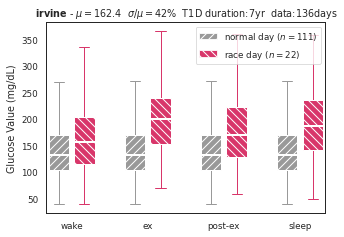

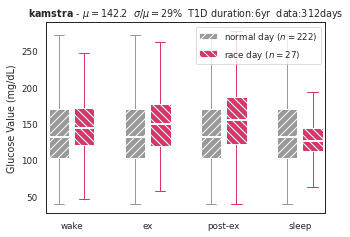

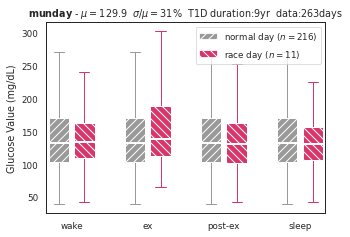

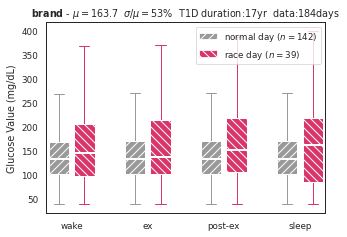

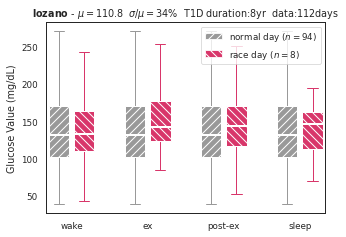

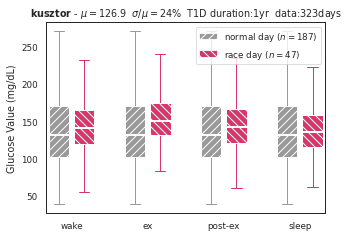

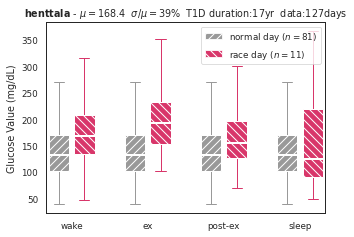

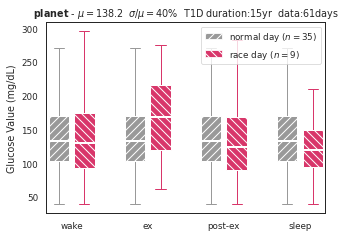

In [29]:
for i in df.RIDER.unique():
	n_nc = len(df.loc[(df.RIDER == i) & (df['race'] == False), 'local_timestamp'].dt.date.unique())
	n_rc = len(df.loc[(df.RIDER == i) & (df['race'] == True), 'local_timestamp'].dt.date.unique())

	fig, ax = plt.subplots(figsize=(5,3.5))
	for k, sec in enumerate(SECTIONS):
		plt.boxplot(df.loc[(df.RIDER == i) & df[sec] & df['race']==False, COL], positions=[k+0.5+k*2], widths=[0.8],
			patch_artist=True, showfliers=False, **kws_box['training'])
		plt.boxplot(df.loc[(df.RIDER == i) & df[sec] & df['race']==True, COL], positions=[k+1.5+k*2], widths=[0.8],
			patch_artist=True, showfliers=False, **kws_box['race'])
	plt.xticks([1,4,7,10], SECTIONS)
	plt.ylabel(COL)
	plt.legend(handles=[Patch(facecolor=nc, edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
						Patch(facecolor=rc, edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
				loc='upper right')
	plt.title(r'$\bf{Rider}$ '+r'$\bf{:d}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(i, df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'boxplot/box_glucose_sections_%s.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'boxplot/box_glucose_sections_%s.png'%i, dpi=300, bbox_inches='tight')
	plt.title(r'$\bf{:s}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(rider_mapping_inv[i], df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'boxplot/box_glucose_sections_%s_NAME.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'boxplot/box_glucose_sections_%s_NAME.png'%i, dpi=300, bbox_inches='tight')
	plt.show()
	plt.close()

All, stratify: athletes

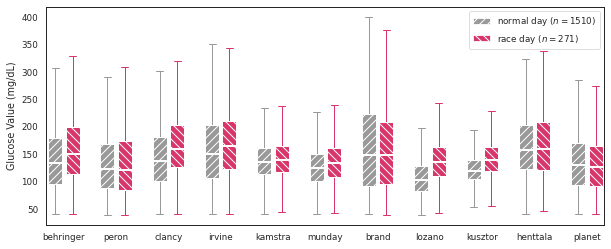

In [30]:
n_nc = len(df.loc[df['race'] == False, ['RIDER', 'date']].drop_duplicates())
n_rc = len(df.loc[df['race'] == True, ['RIDER', 'date']].drop_duplicates())

# hue: athlete
fig, ax = plt.subplots(figsize=(10,4))
for n, i in enumerate(df.RIDER.unique()):
	plt.boxplot(df.loc[(df.RIDER == i) & (df['race'] == False), COL], positions=[n+0.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['training'])
	plt.boxplot(df.loc[(df.RIDER == i) & (df['race'] == True), COL], positions=[n+1.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=nc, edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=rc, edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.xticks([1,4,7,10,13,16,19,22,25,28,31], df.RIDER.unique())
plt.savefig(SAVE_PATH+'boxplot/box_glucose_riders.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'boxplot/box_glucose_riders.png', dpi=300, bbox_inches='tight')
plt.xticks([1,4,7,10,13,16,19,22,25,28,31], [rider_mapping_inv[i] for i in df.RIDER.unique()])
plt.savefig(SAVE_PATH+'boxplot/box_glucose_riders_NAME.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'boxplot/box_glucose_riders_NAME.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Glucose over time (longitudinal)

In [31]:
df_training = pd.read_csv(DATA_PATH+'training.csv', index_col=0)
df_training['timestamp_min'] = pd.to_datetime(df_training['timestamp_min'])
df_training['timestamp_max'] = pd.to_datetime(df_training['timestamp_max'])
df_training['local_timestamp_min'] = pd.to_datetime(df_training['local_timestamp_min'])
df_training['local_timestamp_max'] = pd.to_datetime(df_training['local_timestamp_max'])

df_training['timestamp_min_r'] = df_training['timestamp_min'].round('5min')
df_training['timestamp_max_r'] = df_training['timestamp_max'].round('5min')
df_training['local_timestamp_min_r'] = df_training['local_timestamp_min'].round('5min')
df_training['local_timestamp_max_r'] = df_training['local_timestamp_max'].round('5min')

df_training.set_index(['RIDER', 'file_id'], inplace=True)

In [32]:
# create TID and t
for j, ((i,n), (t_min, t_max)) in enumerate(df_training[['local_timestamp_min_r', 'local_timestamp_max_r']].iterrows()):
	mask = (df.RIDER == i) & (df.local_timestamp >= t_min) & (df.local_timestamp <= t_max)
	df.loc[mask, 'tid'] = j
	df.loc[mask, 't'] = df.loc[mask, 'local_timestamp'] - t_min

df['t'] = df['t'].dt.seconds / 60 # time in minutes

All

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


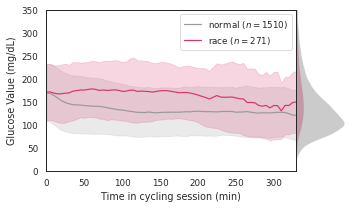

In [33]:
n_nc = len(df.loc[df['race'] == False, ['RIDER', 'date']].drop_duplicates())
n_rc = len(df.loc[df['race'] == True, ['RIDER', 'date']].drop_duplicates())

t_max = df.groupby('tid')['t'].max().quantile(0.9) #df['t'].max()

fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
sns.lineplot(df['t'], df[COL], hue=df['race'], ci='sd', palette=list(color_race.values()), ax=ax[0])
ax[0].set_xlabel('Time in cycling session (min)')
ax[0].legend(loc='upper right', labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 
										'race'r' ($n = {:.0f}$)'.format(n_rc)])
sns.kdeplot(data=df.loc[df['t'].notna()], y=COL, hue='race', ax=ax[1],
	fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])
plt.ylim((0,350))
ax[0].set_xlim((0, t_max))
plt.savefig(SAVE_PATH+'time_cycling/glucose_cycling.pdf', bbox_inches='tight')
plt.savefig(SAVE_PATH+'time_cycling/glucose_cycling.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

Individual athletes

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


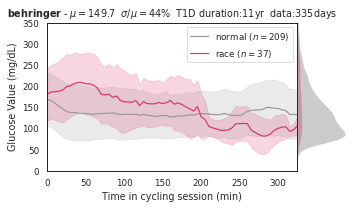

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


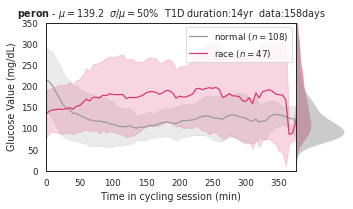

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


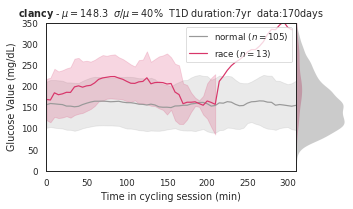

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


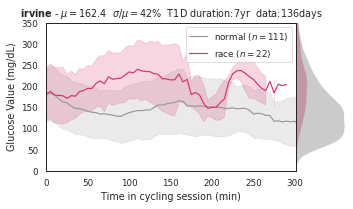

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


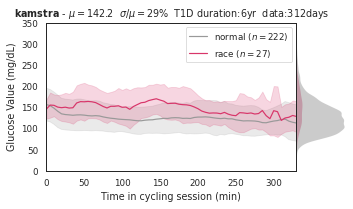

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


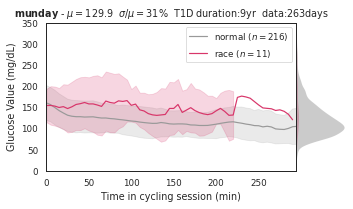

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


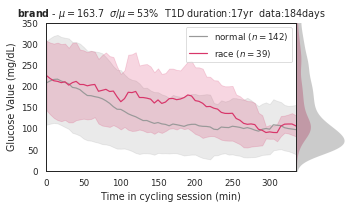

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


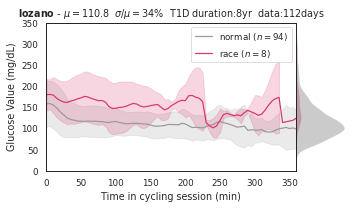

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


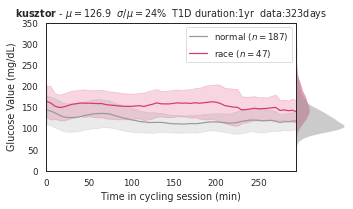

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


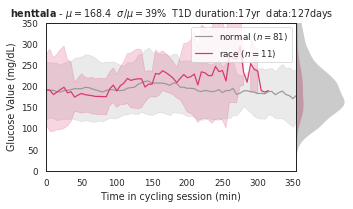

/local/home/evanweenen/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


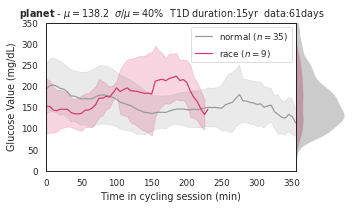

In [37]:
for i in df.RIDER.unique():
	n_nc = len(df.loc[(df.RIDER == i) & (df['race'] == False), 'local_timestamp'].dt.date.unique())
	n_rc = len(df.loc[(df.RIDER == i) & (df['race'] == True), 'local_timestamp'].dt.date.unique())

	t_max = df[df.RIDER == i].groupby('tid')['t'].max().quantile(0.9)#df.loc[df.RIDER == i, 't'].max()

	fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
	sns.lineplot(df.loc[df.RIDER == i,'t'], df.loc[df.RIDER == i, COL], ci='sd', hue=df['race'], palette=list(color_race.values()), ax=ax[0])
	ax[0].set_xlabel('Time in cycling session (min)')
	ax[0].legend(loc='upper right', labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 
											'race'r' ($n = {:.0f}$)'.format(n_rc)])
	sns.kdeplot(data=df.loc[df['t'].notna() & (df.RIDER == i)], y=COL, hue='race', ax=ax[1],
		fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
	sns.despine(bottom=True, right=True, top=True, ax=ax[1])
	ax[1].set(xlabel=None, xticks=[])
	plt.ylim((0,350))
	ax[0].set_xlim((0, t_max))
	ax[0].set_title(r'$\bf{Rider}$ '+r'$\bf{:d}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(i, df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'time_cycling/glucose_cycling_%s.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'time_cycling/glucose_cycling_%s.png'%i, dpi=300, bbox_inches='tight')
	ax[0].set_title(r'$\bf{:s}$ - $\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(rider_mapping_inv[i], df[df.RIDER == i][COL].mean(),
				df[df.RIDER == i][COL].std()/df[df.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				info.loc[i, 'cgm_days']))
	plt.savefig(SAVE_PATH+'time_cycling/glucose_cycling_%s_NAME.pdf'%i, bbox_inches='tight')
	plt.savefig(SAVE_PATH+'time_cycling/glucose_cycling_%s_NAME.png'%i, dpi=300, bbox_inches='tight')
	plt.show()
	plt.close()

In [ ]:
# -------------------------- Descriptives
# TODO: gender (m/f), CSII/MDI
# CGM completeness
# CSII / MDI (1/10)
# VO2max (mL min-1 kg-1)
# IPAQ score (MET min week-1)
dict_stats = {'age'								: 'Age (yr)',
			  'height'							: 'Height (cm)',
			  'weight'							: 'Weight (cm)',
			  'bf(%)'							: 'Fat mass (%)',
			  'diabetes_duration'				: 'Diabetes duration (yr)',
			  'HbA1c'							: 'HbA_{1c} (%)',
			  'cgm_days'						: 'Days with CGM coverage >70 %',
			  'cgm_mean'						: 'Mean glucose (mg/dL)',
			  'cgm_cv'							: 'Glycemic variability (%)',
			  'hypo L2'							: 'hypoglycemia L2 (<54 mg/dL)',
			  'hypo L1'							: 'hypoglycemia L1 (54-69 mg/dL)',
			  'target'							: 'target range (70-180 mg/dL)',
			  'hyper L1'						: 'hyperglycemia L1 (181-250 mg/dL)',
			  'hyper L2'						: 'hyperglycemia L2 (>250 mg/dL)',
			  'FTP_per_kg'						: 'Functional threshold power (W/kg)',
			  'LTHR'							: 'Lactate threshold heart rate (bpm)',
			  'HRmax'							: 'HR_{max} (bpm)',
			  'VO2max'							: 'VO_{2max} (mL/min/kg)',
			  'days_cycled'						: 'Days cycled',
			  'days_raced'						: 'Days participated in competition',
			  'km_cycled'						: 'Distance cycled (km/yr)',
			  'hours_cycled_per_cycling_day'	: 'Mean time cycled (h/day)',
			  'km_cycled_per_cycling_day'		: 'Mean distance cycled (km/day)',
			  'km_ascended_per_cycling_day'		: 'Mean distance ascended (km/day)'}

In [ ]:
glucose_levels = {'hypo L2': (0,53),
				  'hypo L1': (54,69),
				  'target' : (70,180),
				  'hyper L1': (181,250),
				  'hyper L2': (251,10000)}

In [ ]:
# info
info = pd.read_csv(DATA_PATH+'./info.csv', index_col=0)
info.set_index('RIDER', inplace=True)
info['FTP_per_kg'] = info['FTP'] / info['weight']
info.drop('FTP', axis=1, inplace=True)

cols_info = ['age', 'height', 'weight', 'bf(%)']
cols_diabetes = ['diabetes_duration', 'HbA1c']
cols_ex = ['FTP_per_kg', 'LTHR', 'HRmax', 'VO2max']

# cgm
cgm_avail = df.groupby(['RIDER', df.timestamp.dt.date])['Glucose Value (mg/dL)'].count().unstack().count(axis=1).rename('cgm_days')
cgm_mean = df.groupby(['RIDER'])['Glucose Value (mg/dL)'].mean().rename('cgm_mean')
cgm_cv = df.groupby('RIDER')['Glucose Value (mg/dL)'].apply(lambda x: x.std()/x.mean()*100).rename('cgm_cv')
cgm_times = df.groupby(['RIDER']).apply(lambda x: get_percinlevel(x)).apply(pd.Series)
stats_cgm = pd.concat([cgm_avail, cgm_mean, cgm_cv, cgm_times], axis=1)

# trainingpeaks
tp = pd.read_csv(DATA_PATH+'./trainingpeaks_day.csv', index_col=[0,1])
stats_cycling_year = tp.groupby('RIDER').agg({'date'			:'count', # cycling days / yr
											  'race'			:'sum', # race days / yr
											  'distance_max'	:lambda x: x.sum()/1000 # km cycled / yr
											  })\
							.rename(columns={'date'				:'days_cycled',
											 'race'				:'days_raced',
											 'distance_max'		:'km_cycled'})
stats_cycling_day = tp.groupby('RIDER').agg({ 'timestamp_count'			:lambda x: x.mean()/3600, #h cycled / cycling day
											  'distance_max'			:lambda x: x.mean()/1000, # km cycled / cycling day
											  'elevation_gain_up_sum'	:lambda x: x.mean()/1000, # km ascended / cycling day
											})\
							.rename(columns={'timestamp_count'			:'hours_cycled_per_cycling_day',
											 'distance_max'				:'km_cycled_per_cycling_day',
											 'elevation_gain_up_sum'	:'km_ascended_per_cycling_day'})

# combine
descriptives = pd.concat([info[cols_info], info[cols_diabetes], stats_cgm, info[cols_ex], stats_cycling_year, stats_cycling_day], axis=1)
descriptives_sum = pd.concat([descriptives.mean(), descriptives.std()], axis=1)
descriptives_sum = descriptives_sum.round(1).apply(lambda x: '%s $\pm$ %s'%(x[0], x[1]), axis=1).rename(index=dict_stats)
with open(SAVE_PATH+"descriptives.tex", 'w') as file:
	file.write(descriptives_sum.to_latex(column_format='c'))

In [14]:
info = pd.read_csv(DATA_PATH+'./info.csv', index_col=0)
info.set_index('RIDER', inplace=True)
info

,age,diabetes_duration,height,weight,bf(%),HbA1c,FTP,LTHR,HRmax,VO2max
RIDER,,,,,,,,,,
1,22.0,11.0,174.0,60.500000,9.066667,6.7,307.000000,176.333333,192.333333,68.888889
2,30.0,14.0,178.0,71.633333,8.833333,6.6,326.000000,168.666667,181.666667,66.915285
3,26.0,7.0,171.0,66.733333,6.566667,6.8,298.000000,171.000000,180.000000,66.666164
4,19.0,7.0,178.0,78.666667,9.433333,7.8,356.000000,170.333333,187.333333,67.333333
5,25.0,6.0,183.0,69.633333,7.700000,6.5,341.000000,179.666667,192.666667,72.857143
6,20.0,9.0,169.0,56.700000,4.950000,6.4,298.500000,173.000000,184.500000,70.781588
10,27.0,17.0,185.0,75.466667,7.700000,7.3,377.333333,177.000000,194.333333,73.982571
12,30.0,8.0,178.0,64.000000,5.600000,6.0,347.000000,158.333333,178.666667,75.937500
13,34.0,1.0,179.0,60.333333,4.866667,6.3,345.666667,173.000000,182.333333,76.666667


In [27]:
percinlevel = {i:get_percinlevel(df[df.RIDER == i]) for i in df.RIDER.unique()}
percinlevel = pd.DataFrame(percinlevel).T
percinlevel['hypo'] = percinlevel['hypo L2'] + percinlevel['hypo L1']
percinlevel['hyper'] = percinlevel['hyper L1'] + percinlevel['hyper L2']
percinlevel

,hypo L2,hypo L1,target,hyper L1,hyper L2,hypo,hyper
1,1.209455,6.730493,64.032547,19.491675,8.535830,7.939947,28.027506
2,3.319630,8.091153,66.078939,14.069814,8.224224,11.410783,22.294038
3,1.387432,4.821754,67.102023,20.653035,6.035756,6.209185,26.688791
4,1.772771,3.610159,57.773782,26.127999,10.715289,5.382930,36.843288
5,0.219195,1.275101,83.175026,13.625436,1.596823,1.494296,15.222259
6,0.450731,2.496993,86.588687,9.486084,0.966444,2.947724,10.452528
10,7.973185,6.257463,47.707133,20.995077,17.065047,14.230648,38.060124
12,2.273402,9.284984,83.716633,4.368628,0.326657,11.558386,4.695285
13,0.018693,0.447523,93.712683,5.647369,0.169333,0.466216,5.816702
14,0.309965,1.706257,62.468134,23.988992,11.309386,2.016222,35.298378


In [28]:
diab = pd.concat([info, percinlevel], axis=1)
diab

,age,diabetes_duration,height,weight,bf(%),HbA1c,FTP,LTHR,HRmax,VO2max,hypo L2,hypo L1,target,hyper L1,hyper L2,hypo,hyper
1,22.0,11.0,174.0,60.500000,9.066667,6.7,307.000000,176.333333,192.333333,68.888889,1.209455,6.730493,64.032547,19.491675,8.535830,7.939947,28.027506
2,30.0,14.0,178.0,71.633333,8.833333,6.6,326.000000,168.666667,181.666667,66.915285,3.319630,8.091153,66.078939,14.069814,8.224224,11.410783,22.294038
3,26.0,7.0,171.0,66.733333,6.566667,6.8,298.000000,171.000000,180.000000,66.666164,1.387432,4.821754,67.102023,20.653035,6.035756,6.209185,26.688791
4,19.0,7.0,178.0,78.666667,9.433333,7.8,356.000000,170.333333,187.333333,67.333333,1.772771,3.610159,57.773782,26.127999,10.715289,5.382930,36.843288
5,25.0,6.0,183.0,69.633333,7.700000,6.5,341.000000,179.666667,192.666667,72.857143,0.219195,1.275101,83.175026,13.625436,1.596823,1.494296,15.222259
6,20.0,9.0,169.0,56.700000,4.950000,6.4,298.500000,173.000000,184.500000,70.781588,0.450731,2.496993,86.588687,9.486084,0.966444,2.947724,10.452528
10,27.0,17.0,185.0,75.466667,7.700000,7.3,377.333333,177.000000,194.333333,73.982571,7.973185,6.257463,47.707133,20.995077,17.065047,14.230648,38.060124
12,30.0,8.0,178.0,64.000000,5.600000,6.0,347.000000,158.333333,178.666667,75.937500,2.273402,9.284984,83.716633,4.368628,0.326657,11.558386,4.695285
13,34.0,1.0,179.0,60.333333,4.866667,6.3,345.666667,173.000000,182.333333,76.666667,0.018693,0.447523,93.712683,5.647369,0.169333,0.466216,5.816702
14,27.0,17.0,187.0,75.166667,9.333333,7.1,348.000000,169.000000,189.500000,66.500000,0.309965,1.706257,62.468134,23.988992,11.309386,2.016222,35.298378


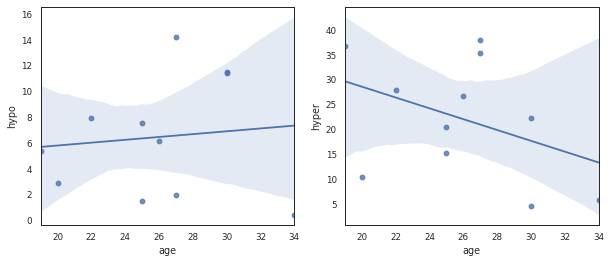

In [34]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.regplot(x='age', y='hypo', data=diab, ax=axs[0])
sns.regplot(x='age', y='hyper', data=diab, ax=axs[1])
plt.show()

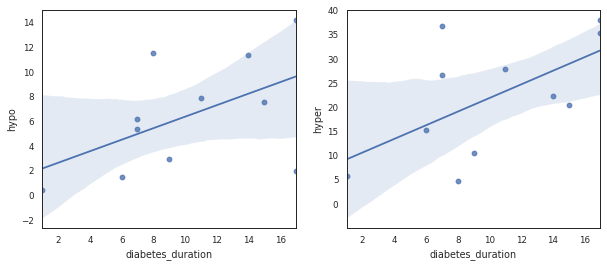

In [37]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.regplot(x='diabetes_duration', y='hypo', data=diab, ax=axs[0])
sns.regplot(x='diabetes_duration', y='hyper', data=diab, ax=axs[1])
plt.show()

In [39]:
import statsmodels.api as sm

diab = sm.add_constant(diab)

model = sm.OLS(diab['hypo'], diab[info.columns])
res = model.fit()
print(res.summary())

model = sm.OLS(diab['hyper'], diab[info.columns])
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                   hypo   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.858
Method:                 Least Squares   F-statistic:                              7.657
Date:                Tue, 26 Oct 2021   Prob (F-statistic):                       0.275
Time:                        21:19:31   Log-Likelihood:                         -14.273
No. Observations:                  11   AIC:                                      48.55
Df Residuals:                       1   BIC:                                      52.53
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
